# Tech Challenge 2 - Previsão de Tendência do IBOVESPA

## Estrutura inicial com base nas aulas da pós
Este projeto tem como objetivo prever se o IBOVESPA terá uma alta ou queda no dia seguinte, utilizando duas abordagens:
- Modelos de séries temporais (ARIMA), para prever valores futuros e extrair direção;
- Modelos supervisionados de classificação (como Regressão Logística e Random Forest), para prever a direção com base em variáveis derivadas.

A proposta do desafio exige transformar a previsão numérica em uma classificação binária de direção: 1 (alta), 0 (queda).

A base de dados contém informações diárias do índice IBOVESPA no período de 30/06/2023 a 30/06/2025. Cada linha representa um pregão da bolsa de valores. 

As variáveis presentes na base são:
- Data: Data do pregão, atualmente no formato string, que será convertida para datetime para facilitar ordenação e manipulação temporal.
- Último: Valor de fechamento do IBOVESPA no final do dia, representado em mil pontos. Tipo float.
- Abertura: Valor de abertura do IBOVESPA no início do dia, também em mil pontos. Tipo float.
- Máxima: Maior valor alcançado pelo IBOVESPA durante o dia. Tipo float.
- Mínima: Menor valor alcançado pelo IBOVESPA durante o dia. Tipo float.
- Vol.: Volume financeiro negociado no dia, representado como string com sufixo “B” para bilhões (exemplo: 7,68B). Essa variável será convertida para número absoluto (float) posteriormente.
- Var%: Variação percentual diária do IBOVESPA, representada como string com símbolo de porcentagem e vírgula como decimal (exemplo: +1,45%). Será convertida para número decimal (float) para uso no modelo.


## 1 - Importação das bibliotecas

In [1]:
# Importação das bibliotecas necessárias para manipulação de dados, visualização e modelagem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos estatísticos e machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## 2 - Carregamento e transformacao dos dados

In [2]:
# Carregar csv
df = pd.read_csv('techchallenge_Ibovespa.csv')

# Visualização inicial
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,30.06.2025,138.855,136.865,139.103,136.430,"7,68B","1,45%"
1,27.06.2025,136.866,137.113,137.209,136.469,"6,24B","-0,18%"
2,26.06.2025,137.114,135.767,137.353,135.756,"8,02B","0,99%"
3,25.06.2025,135.767,137.163,137.163,135.565,"7,71B","-1,02%"
4,24.06.2025,137.165,136.552,138.156,136.254,"8,08B","0,45%"


### Verificando tipos de dados e informações gerais

In [3]:
#ver tipo de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      498 non-null    object 
 1   Último    498 non-null    float64
 2   Abertura  498 non-null    float64
 3   Máxima    498 non-null    float64
 4   Mínima    498 non-null    float64
 5   Vol.      498 non-null    object 
 6   Var%      498 non-null    object 
dtypes: float64(4), object(3)
memory usage: 27.4+ KB


In [4]:
#métricas iniciais
df.describe()

,Último,Abertura,Máxima,Mínima
count,498.000000,498.000000,498.000000,498.000000
mean,126.639944,126.599357,127.417908,125.861281
std,6.319785,6.306578,6.275376,6.308730
min,112.532000,112.534000,113.597000,111.599000
25%,122.159250,122.101250,122.837750,121.266500
50%,127.317000,127.311000,127.994500,126.496500
75%,130.777250,130.710500,131.502000,130.053500
max,140.110000,140.109000,140.382000,138.966000


In [5]:
# Corrigir valores com 'B' e 'M'
df['Vol.'] = (df['Vol.'].str.replace('.', '', regex=False)
                         .str.replace(',', '.', regex=False)
                         .str.replace('B', '', regex=False)
                         .str.replace('M', '', regex=False)
                         .astype(float))

# Ajustar escala
df.loc[df['Vol.'] < 1000, 'Vol.'] *= 1e6  # Se for 'M', multiplica por 1 milhão
df.loc[df['Vol.'] >= 1000, 'Vol.'] *= 1e9  # Se for 'B' já limpado, multiplica por 1 bilhão

In [6]:
#validar
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      498 non-null    object 
 1   Último    498 non-null    float64
 2   Abertura  498 non-null    float64
 3   Máxima    498 non-null    float64
 4   Mínima    498 non-null    float64
 5   Vol.      498 non-null    float64
 6   Var%      498 non-null    object 
dtypes: float64(5), object(2)
memory usage: 27.4+ KB


In [7]:
#date para datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y', dayfirst=True)
df = df.sort_values(by='Data').reset_index(drop=True)

In [8]:
#Converter a coluna Var% para float (para correlação, gráficos, etc):
df['Var%'] = (df['Var%']
              .str.replace(',', '.', regex=False)
              .str.replace('%', '', regex=False)
              .astype(float))

In [9]:
#validar
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      498 non-null    datetime64[ns]
 1   Último    498 non-null    float64       
 2   Abertura  498 non-null    float64       
 3   Máxima    498 non-null    float64       
 4   Mínima    498 non-null    float64       
 5   Vol.      498 non-null    float64       
 6   Var%      498 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 27.4 KB


### 2 - Exploraçao de dados (EDA)


#### 1 - Como o IBOVESPA evoluiu ao longo dos últimos 2 anos?
Entender padrões de alta, baixa, estabilidade ou volatilidade no tempo.


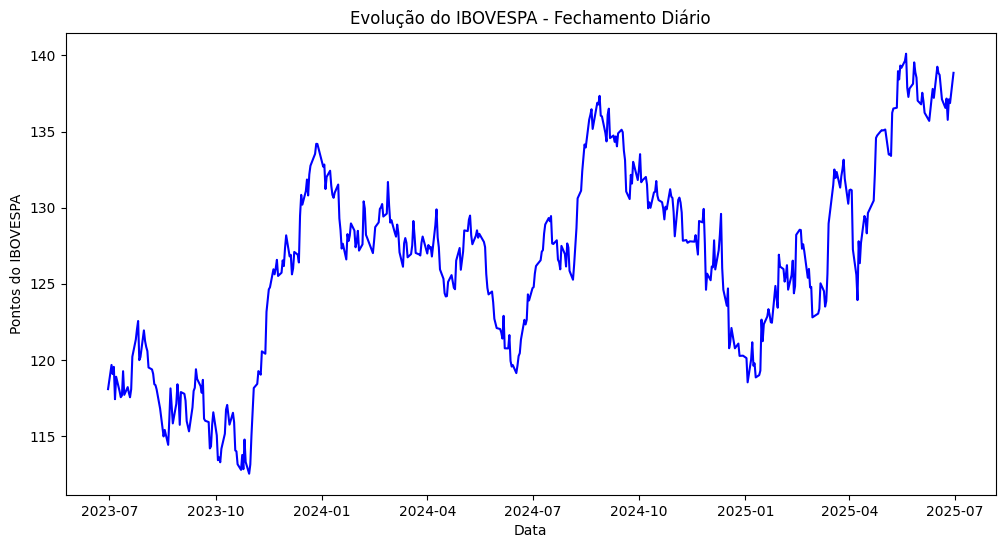

In [10]:
#linha temporal
plt.figure(figsize=(12, 6))
plt.plot(df['Data'], df['Último'], color='blue')
plt.title('Evolução do IBOVESPA - Fechamento Diário')
plt.xlabel('Data')
plt.ylabel('Pontos do IBOVESPA')
plt.show()

##### Possiveis análises:
    1. O IBOVESPA passou por ciclos claros de alta e baixa nesse período.
	2.	Existe uma volatilidade relevante: o índice varia com certa frequência, não há estabilidade constante.
	3.	Alguns momentos apresentam quedas bruscas seguidas de recuperações rápidas (ex.: fim de 2023 e meados de 2024).
	4.	Nos últimos meses, o índice está em uma tendência de alta consistente, recuperando patamares próximos aos maiores do período.

#### 2 - Qual é o comportamento das variações diárias? Elas são pequenas, grandes, ou extremas?
 Entender se as variações são concentradas próximas de 0 (mercado estável) ou se há muitas oscilações extremas.

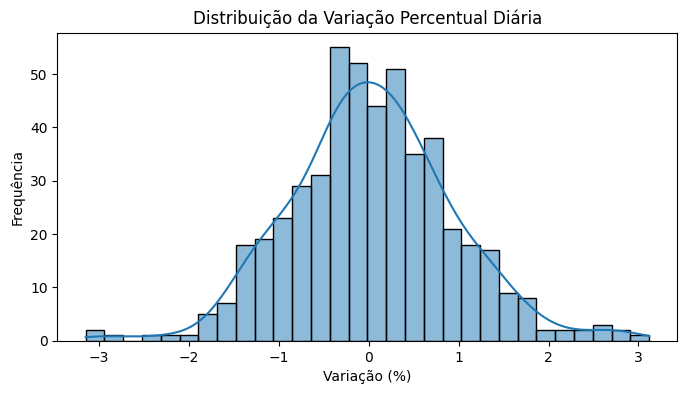

In [11]:
#Histograma + KDE (densidade)
plt.figure(figsize=(8, 4))
sns.histplot(df['Var%'], bins=30, kde=True)
plt.title('Distribuição da Variação Percentual Diária')
plt.xlabel('Variação (%)')
plt.ylabel('Frequência')
plt.show()

##### Possiveis análises:
	1.	A distribuição da variação percentual diária do IBOVESPA é concentrada perto de 0%.
	2.	A maioria dos pregões oscila entre -1% e +1%.
	3.	Existem poucos dias com variações extremas acima de +2% ou abaixo de -2%.
	4.	O formato da distribuição lembra uma curva normal (Gaussiana, onde a maior parte dos valores está concentrada perto da média.), com leve viés negativo (cauda mais alongada no lado das quedas).

#### 3 - Existe relação entre volume negociado e a variação percentual do índice?
Ver se grandes volumes costumam gerar maiores oscilações (pode sugerir feature).

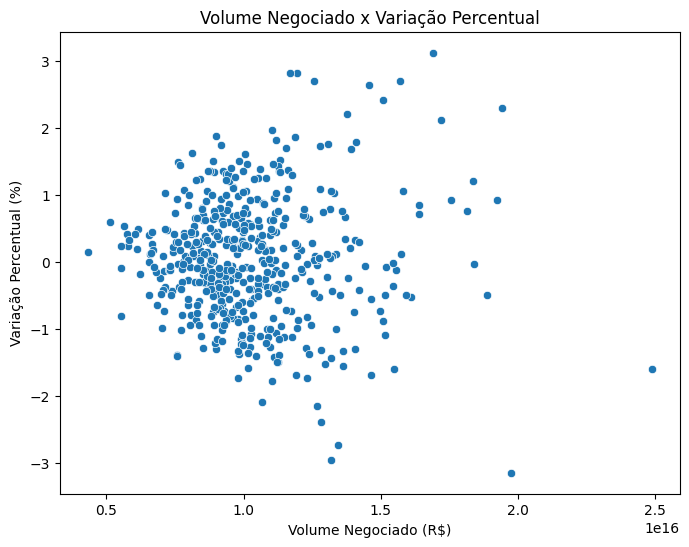

In [12]:
#Dispersao
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Vol.'], y=df['Var%'])
plt.title('Volume Negociado x Variação Percentual')
plt.xlabel('Volume Negociado (R$)')
plt.ylabel('Variação Percentual (%)')
plt.show()

##### Possiveis análises:
	1.	Não há uma relação clara ou direta entre o volume negociado e a variação percentual.
	2.	Mesmo com volumes mais altos ou mais baixos, o IBOVESPA tende a oscilar de forma semelhante.
	3.	O comportamento das variações diárias está mais concentrado entre -1% e +1%, independentemente do volume.
	4.	O único ponto fora da curva (outlier) é um volume muito alto, mas com variação negativa moderada.
Esse ponto não representa um padrão, é exceção.

#### 4 - O IBOVESPA subiu ou caiu mais vezes nesse período?
Entender o equilíbrio da base entre dias de alta e queda. Ajuda a refletir sobre balanceamento do target.

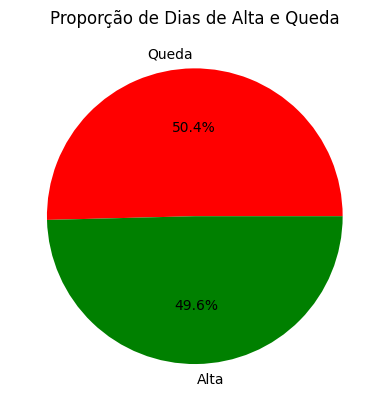

In [13]:
#Grafico de pizza
df['Alta'] = df['Var%'] > 0
df['Alta'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Queda', 'Alta'], colors=['red', 'green'])
plt.title('Proporção de Dias de Alta e Queda')
plt.ylabel('')
plt.show()

##### Possiveis análises:
	1.  O dataset está praticamente equilibrado entre dias de alta e dias de queda.
	2.	50,4% dos dias foram de queda e 49,6% de alta.
	3.	Isso indica que o IBOVESPA nesse período não teve uma tendência clara e consistente para um dos lados (alta ou baixa).

#### 5 - Quais variáveis numéricas se relacionam mais entre si?
Descobrir quais variáveis estão mais conectadas (e evitar duplicar informação nas features).

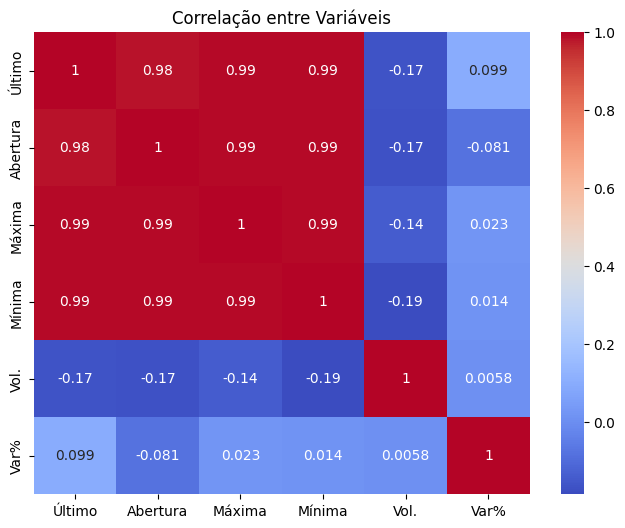

In [14]:
#matriz de correlacao
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre Variáveis')
plt.show()

##### Possiveis análises:
	1.	As variáveis Último, Abertura, Máxima e Mínima têm correlação altíssima entre si (praticamente 1). Isso é esperado, pois todas medem diferentes momentos do mesmo pregão e tendem a andar juntas.
	2.	O Volume negociado (Vol.) não tem correlação relevante com as demais. Reflete o scatterplot: volume não explica variação.
	3.	A Var% também não tem correlação forte com as demais. Isso reforça a ideia de que as variações diárias não seguem linearmente as outras variáveis.

In [15]:
#a média só das variações positivas
media_var_positiva = df[df['Var%'] > 0]['Var%'].mean()
print(media_var_positiva)

0.7293227091633466


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      498 non-null    datetime64[ns]
 1   Último    498 non-null    float64       
 2   Abertura  498 non-null    float64       
 3   Máxima    498 non-null    float64       
 4   Mínima    498 non-null    float64       
 5   Vol.      498 non-null    float64       
 6   Var%      498 non-null    float64       
 7   Alta      498 non-null    bool          
dtypes: bool(1), datetime64[ns](1), float64(6)
memory usage: 27.8 KB


## 3 - Criação de novas variáveis (Feature Engineering)

In [17]:
#Criar a Variação diária de fechamento
df['Variação'] = df['Último'].diff()

In [18]:
#Criar média movel de 5 dias (Captura tendência recente)
df['SMA_5'] = df['Último'].rolling(window=5).mean()

In [19]:
#Criar média movel de 10 dias (Captura tendência um pouco mais ampla)
df['SMA_10'] = df['Último'].rolling(window=10).mean()

In [20]:
#Criar média movel de 20 dias (Captura tendência um pouco mais ampla)
df['SMA_20'] = df['Último'].rolling(window=20).mean()

In [21]:
#Criar lag de fechamento de 1 dia (Mostra o fechamento do dia anterior)
df['Último_Lag1'] = df['Último'].shift(1)

In [22]:
#ver dados
df[['Data', 'Variação', 'SMA_5', 'SMA_10', 'Último_Lag1']].head(10)

,Data,Variação,SMA_5,SMA_10,Último_Lag1
0,2023-06-30,NaN,NaN,NaN,NaN
1,2023-07-03,1.586,NaN,NaN,118.087
2,2023-07-04,-0.597,NaN,NaN,119.673
3,2023-07-05,0.473,NaN,NaN,119.076
4,2023-07-06,-2.123,118.7622,NaN,119.549
5,2023-07-07,1.472,118.9244,NaN,117.426
6,2023-07-10,-0.956,118.5782,NaN,118.898
7,2023-07-11,-0.386,118.2742,NaN,117.942
8,2023-07-12,0.110,117.8976,NaN,117.556
9,2023-07-13,1.598,118.2652,118.5137,117.666


In [23]:
#remover NaN
df = df.dropna()

In [24]:
#ver se ainda tem NaN
df[df[['Variação', 'SMA_5', 'SMA_10', 'Último_Lag1']].isnull().any(axis=1)]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Alta,Variação,SMA_5,SMA_10,SMA_20,Último_Lag1


<Figure size 1200x600 with 0 Axes>

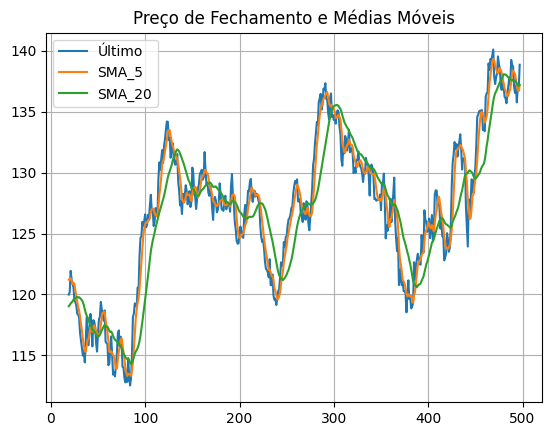

In [25]:
plt.figure(figsize=(12,6))
df[['Último', 'SMA_5', 'SMA_20']].plot(title='Preço de Fechamento e Médias Móveis')
plt.grid(True)
plt.show()

## 4 - Definir variável-alvo (Target)
- Primeira tentativa: (obtive 40% e 47% de acurácia): Criacao da variável Target comparando o fechamento do dia seguinte com o do dia atual. Se o fechamento do próximo pregão foi maior, o dia atual recebe 1 (Alta). Caso contrário, recebe 0 (Queda). Assim, definimos claramente o comportamento que queremos que o modelo aprenda a prever.
- Segunda tentativa: Para este projeto, defini o target com base no cruzamento de médias móveis, o target recebe valor **1 (Alta)** quando a média móvel de 5 dias (SMA_5) ultrapassa a média móvel de 20 dias (SMA_20), indicando possível sinal de compra. Caso contrário, recebe **0 (Queda)**, indicando possível sinal de venda ou retração.

In [26]:
#Cruzamento de Médias Móveis
df['Target'] = (df['SMA_5'] > df['SMA_20']).astype(int)
df.dropna(inplace=True)
print("Distribuição do Target:")
print(df['Target'].value_counts(normalize=True))

Distribuição do Target:
Target
0    0.524008
1    0.475992
Name: proportion, dtype: float64


## 6 - Regressao: Escalonamento dos dados
Exemplo com StandardScaler e MinMaxScaler.

In [27]:
from sklearn.preprocessing import StandardScaler

# Features que você pretende usar no modelo
features = ['Último', 'SMA_5', 'SMA_10', 'SMA_20', 'Último_Lag1', 'Variação']

# Inicializar scaler
scaler = StandardScaler()

# Aplicar o escalonamento nas features
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

In [28]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Alta,Variação,SMA_5,SMA_10,SMA_20,Último_Lag1,Target
19,2023-07-27,119.990,122.560,122.599,119.825,1.068000e+16,-2.10,False,-2.570,121.2234,119.5523,119.0330,122.560,1
20,2023-07-28,120.187,120.002,120.660,119.706,8.460000e+15,0.16,True,0.197,121.2174,119.7999,119.1380,119.990,1
21,2023-07-31,121.943,120.188,122.149,120.188,1.012000e+16,1.46,True,1.756,121.3376,120.1723,119.2515,120.187,1
22,2023-08-01,121.248,121.945,121.945,120.154,1.030000e+16,-0.57,False,-0.695,121.1856,120.5130,119.3601,121.943,1
23,2023-08-02,120.859,121.249,121.252,119.798,1.057000e+16,-0.32,False,-0.389,120.8454,120.8437,119.4256,121.248,1


In [29]:
# Selecionar as colunas de entrada e o target
X = df_scaled[['Último', 'SMA_5', 'SMA_10', 'SMA_20', 'Último_Lag1', 'Variação']]
y = df_scaled['Target']

In [30]:
# Separar treino e teste com base em data (time series)
X_train = X.iloc[:-30]
X_test = X.iloc[-30:]
y_train = y.iloc[:-30]
y_test = y.iloc[-30:]

In [31]:
from sklearn.linear_model import LogisticRegression

# Instanciar e treinar o modelo
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Previsão
y_pred_lr = model_lr.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Acurácia:", accuracy_score(y_test, y_pred_lr))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_lr))

Acurácia: 0.8666666666666667

Matriz de Confusão:
[[14  0]
 [ 4 12]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        14
           1       1.00      0.75      0.86        16

    accuracy                           0.87        30
   macro avg       0.89      0.88      0.87        30
weighted avg       0.90      0.87      0.87        30



In [33]:
# Última previsão da regressão
target_lr_binario = y_pred_lr[-1]
print(f"Última previsão da Regressão Logística: {target_lr_binario}")

Última previsão da Regressão Logística: 0


## Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Instanciar o modelo
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar com os dados de treino
modelo_rf.fit(X_train, y_train)

# Fazer previsões
y_pred_rf = modelo_rf.predict(X_test)

In [35]:
# Últimos 30 dias do dataset
ultimos_30_rf = X[-30:]
target_rf_bin_30 = modelo_rf.predict(ultimos_30_rf)

In [36]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report

print("Avaliação do Random Forest:")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf))

Avaliação do Random Forest:
Acurácia: 0.5333333333333333
Recall: 1.0
F1 Score: 0.6956521739130435

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.53      1.00      0.70        16

    accuracy                           0.53        30
   macro avg       0.27      0.50      0.35        30
weighted avg       0.28      0.53      0.37        30



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

## 7 - Serie temporal: ARIMA

In [37]:
#Preparar série temporal com índice de data
df_series = df[['Data', 'Último']].copy()
df_series.set_index('Data', inplace=True)

In [38]:
#Teste de estacionariedade com ADF
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_series['Último'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.687683843015846
p-value: 0.4374690419900557


In [39]:
# Aplicar diferenciação de primeira ordem
df_series['diff'] = df_series['Último'].diff()
df_series.dropna(inplace=True)

# Testar novamente com a série diferenciada
result = adfuller(df_series['diff'])
print(f"ADF Statistic após diferenciação: {result[0]}")
print(f"p-value após diferenciação: {result[1]}")

ADF Statistic após diferenciação: -22.098938416073988
p-value após diferenciação: 0.0


In [40]:
from statsmodels.tsa.arima.model import ARIMA

# Treinar o modelo ARIMA na série diferenciada
modelo_arima = ARIMA(df_series['Último'], order=(1, 1, 1))  # p=1, d=1, q=1
modelo_treinado = modelo_arima.fit()

# Visualizar o sumário do modelo
print(modelo_treinado.summary())

                               SARIMAX Results                                
Dep. Variable:                 Último   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -736.952
Date:                Sun, 27 Jul 2025   AIC                           1479.905
Time:                        14:09:05   BIC                           1492.407
Sample:                             0   HQIC                          1484.821
                                - 478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3399      1.578      0.215      0.829      -2.752       3.432
ma.L1         -0.3630      1.562     -0.232      0.816      -3.425       2.699
sigma2         1.2867      0.071     18.059      0.0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [41]:
# Previsão com o modelo ARIMA treinado
forecast_arima = modelo_treinado.forecast(steps=30)  # Prever os próximos 30 dias

# Pegar o último valor real da série
ultimo_real = df_series['Último'].iloc[-1]

# Pegar o último valor previsto (30º dia da previsão)
ultimo_previsto = forecast_arima.iloc[-1]

# Calcular a variação prevista
variacao_prevista = ultimo_previsto - ultimo_real
print(f'Variação prevista: {variacao_prevista:.2f} pontos')

# Calcular a média histórica das variações positivas (se ainda não fez)
media_alta_real = df['Var%'][df['Var%'] > 0].mean()
print(f"Média histórica de variações positivas: {media_alta_real:.2f}")


Variação prevista: -0.07 pontos
Média histórica de variações positivas: 0.72


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


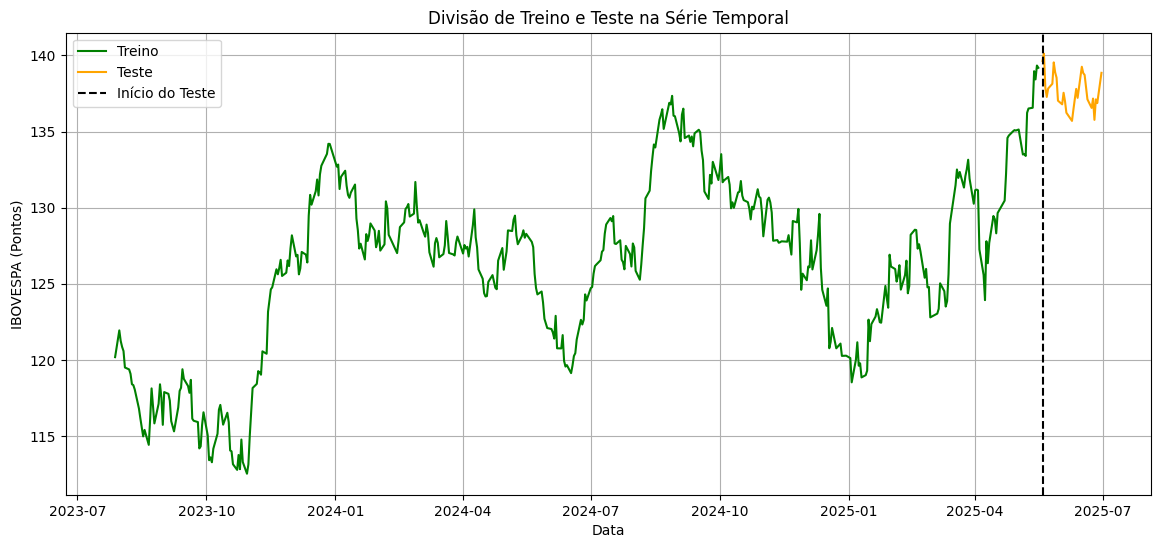

In [42]:
import matplotlib.pyplot as plt

# Definir datas para treino e teste
n_test = 30  # por exemplo: últimos 30 dias para teste
n_total = len(df_series)
train = df_series.iloc[:n_total - n_test]
test = df_series.iloc[n_total - n_test:]

# Plotar
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Último'], label='Treino', color='green')
plt.plot(test.index, test['Último'], label='Teste', color='orange')
plt.axvline(test.index[0], color='black', linestyle='--', label='Início do Teste')
plt.title('Divisão de Treino e Teste na Série Temporal')
plt.xlabel('Data')
plt.ylabel('IBOVESPA (Pontos)')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Calcular a média das variações positivas reais
media_alta_real = df['Var%'][df['Var%'] > 0].mean()
print(f"Média histórica de variações positivas: {media_alta_real:.2f}")

Média histórica de variações positivas: 0.72


In [44]:
#Calcular variação prevista para o 30º dia
ultimo_real = df_series['Último'].iloc[-1]
ultimo_previsto = forecast_arima.iloc[-1]

variacao_prevista = ultimo_previsto - ultimo_real
print(f'Variação prevista: {variacao_prevista:.2f} pontos')

Variação prevista: -0.07 pontos


In [45]:
# Criar target binário com base na variação prevista
target_arima_binario = 1 if variacao_prevista >= media_alta_real else 0
print(f"Target binário previsto pelo ARIMA: {target_arima_binario}")

Target binário previsto pelo ARIMA: 0


## Comparar acertos e erros dos dois modelos

In [46]:
forecast_arima_30 = modelo_treinado.forecast(steps=30)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [47]:
# Calcular a variação prevista nos últimos 30 dias (ARIMA)
ultimos_reais = df_series['Último'].iloc[-31:-1].values
variacoes_previstas = forecast_arima_30.values - ultimos_reais

# Converter para binário com base na média histórica de altas reais
media_alta_real = df['Var%'][df['Var%'] > 0].mean()
arima_bin_30 = (variacoes_previstas >= media_alta_real).astype(int)

# Targets reais e previstos
target_real_30 = df_scaled['Target'].iloc[-30:].values
target_lr_bin_30 = y_pred_lr[-30:]

In [48]:
# Comparar modelos
df_comparacao = pd.DataFrame({
    'Data': df['Data'].iloc[-30:].values,
    'Target Real': target_real_30,
    'Previsão Regressão': target_lr_bin_30,
    'Previsão ARIMA': arima_bin_30,
    'Previsão RF': target_rf_bin_30
})

# Coluna de acerto
df_comparacao['Acerto Regressão'] = df_comparacao['Target Real'] == df_comparacao['Previsão Regressão']
df_comparacao['Acerto ARIMA'] = df_comparacao['Target Real'] == df_comparacao['Previsão ARIMA']
df_comparacao['Acerto RF'] = df_comparacao['Target Real'] == df_comparacao['Previsão RF']

# Usar emojis se quiser
df_comparacao['Acerto Regressão'] = df_comparacao['Acerto Regressão'].apply(lambda x: '✔️' if x else '❌')
df_comparacao['Acerto ARIMA'] = df_comparacao['Acerto ARIMA'].apply(lambda x: '✔️' if x else '❌')
df_comparacao['Acerto RF'] = df_comparacao['Acerto RF'].apply(lambda x: '✔️' if x else '❌')

# Exibir tabela
display(df_comparacao)

# Contar acertos e erros
acertos_regressao = df_comparacao['Acerto Regressão'].value_counts().get('✔️', 0)
erros_regressao = df_comparacao['Acerto Regressão'].value_counts().get('❌', 0)

acertos_arima = df_comparacao['Acerto ARIMA'].value_counts().get('✔️', 0)
erros_arima = df_comparacao['Acerto ARIMA'].value_counts().get('❌', 0)

acertos_rf = df_comparacao['Acerto RF'].value_counts().get('✔️', 0)
erros_rf = df_comparacao['Acerto RF'].value_counts().get('❌', 0)

# Imprimir resultado
print(f"\n Regressão Logística – Acertos: {acertos_regressao}, Erros: {erros_regressao}")
print(f" ARIMA – Acertos: {acertos_arima}, Erros: {erros_arima}")
print(f" Random Forest – Acertos: {acertos_rf}, Erros: {erros_rf}")

,Data,Target Real,Previsão Regressão,Previsão ARIMA,Previsão RF,Acerto Regressão,Acerto ARIMA,Acerto RF
0,2025-05-19,1,1,0,1,✔️,❌,✔️
1,2025-05-20,1,1,0,1,✔️,❌,✔️
2,2025-05-21,1,1,0,1,✔️,❌,✔️
3,2025-05-22,1,1,1,1,✔️,✔️,✔️
4,2025-05-23,1,1,1,1,✔️,✔️,✔️
5,2025-05-26,1,1,1,1,✔️,✔️,✔️
6,2025-05-27,1,1,0,1,✔️,❌,✔️
7,2025-05-28,1,1,0,1,✔️,❌,✔️
8,2025-05-29,1,1,0,1,✔️,❌,✔️
9,2025-05-30,1,1,0,1,✔️,❌,✔️



 Regressão Logística – Acertos: 26, Erros: 4
 ARIMA – Acertos: 6, Erros: 24
 Random Forest – Acertos: 16, Erros: 14


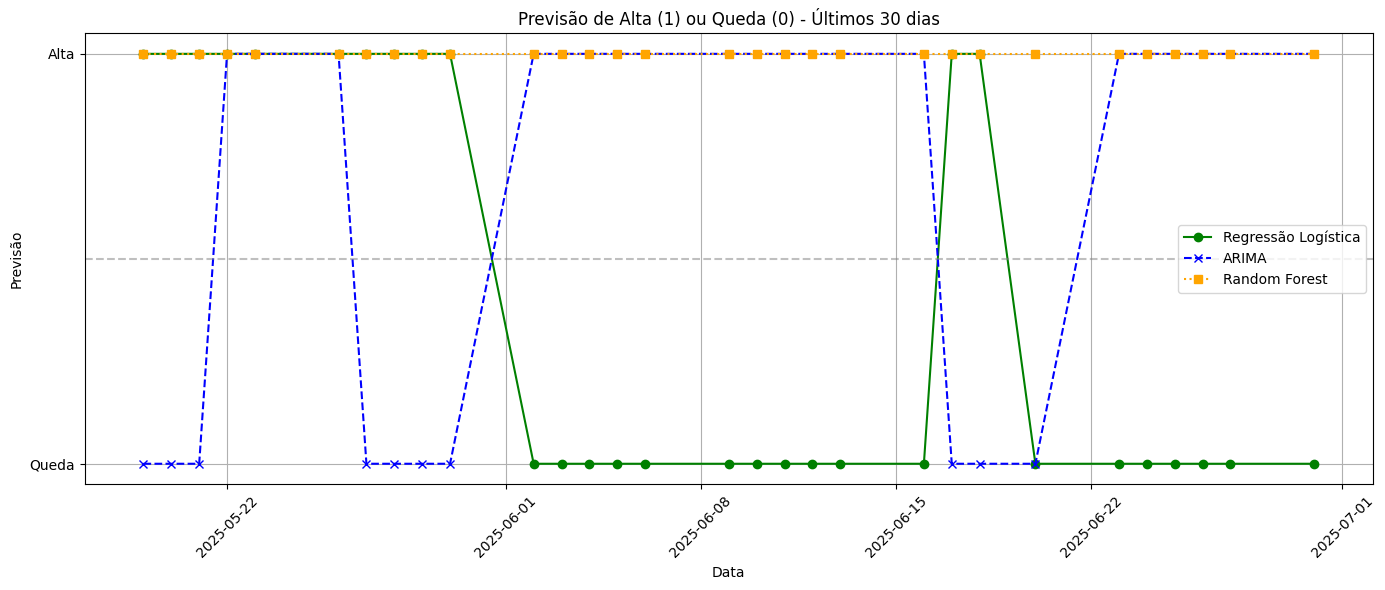

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot da previsão da regressão logística
plt.plot(df_comparacao['Data'], df_comparacao['Previsão Regressão'], marker='o', linestyle='-', label='Regressão Logística', color='green')

# Plot da previsão do ARIMA
plt.plot(df_comparacao['Data'], df_comparacao['Previsão ARIMA'], marker='x', linestyle='--', label='ARIMA', color='blue')

# Plot da previsão do Random Forest
plt.plot(df_comparacao['Data'], df_comparacao['Previsão RF'], marker='s', linestyle=':', label='Random Forest', color='orange')

# Linha de referência separando alta (1) e queda (0)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Ajustes do gráfico
plt.title('Previsão de Alta (1) ou Queda (0) - Últimos 30 dias')
plt.xlabel('Data')
plt.ylabel('Previsão')
plt.yticks([0, 1], ['Queda', 'Alta'])
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Cálculo da acurácia e métricas do ARIMA
print("🔍 Avaliação do ARIMA (binário):")
print("Acurácia:", accuracy_score(target_real_30, arima_bin_30))
print("\nMatriz de Confusão:")
print(confusion_matrix(target_real_30, arima_bin_30))
print("\nRelatório de Classificação:")
print(classification_report(target_real_30, arima_bin_30))

🔍 Avaliação do ARIMA (binário):
Acurácia: 0.2

Matriz de Confusão:
[[ 0 14]
 [10  6]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.30      0.38      0.33        16

    accuracy                           0.20        30
   macro avg       0.15      0.19      0.17        30
weighted avg       0.16      0.20      0.18        30



# Justificativa técnica

## Por que escolhi esses modelos (Regressão Logística, Random Forest e ARIMA):
Por que escolhi esses modelos (Regressão Logística, Random Forest e ARIMA):

No projeto, utilizei três abordagens complementares para reforçar o aprendizado e comparar o desempenho preditivo de modelos distintos:
- Regressão Logística: Escolhi esse modelo por ser simples, eficiente e adequado para problemas de classificação binária, como prever se o IBOVESPA terá alta ou queda. Ele serviu como um bom baseline e apresentou excelente desempenho, acertando 26 dos 30 dias (27 acertos de 30).
- Random Forest: Adicionei esse modelo como alternativa mais robusta baseada em ensemble, que utiliza diversas árvores de decisão para reduzir o risco de overfitting e capturar padrões não lineares nos dados. Ele obteve performance intermediária: 16 acertos nos 30 dias, o que mostra que apesar de menos preciso que a regressão logística nesse cenário, ainda conseguiu identificar parte relevante do comportamento do índice. Sua vantagem é a capacidade de lidar com interações complexas entre as variáveis.
- ARIMA (Séries Temporais): Usei o ARIMA como abordagem complementar, voltada para previsão de valores contínuos respeitando a estrutura sequencial da série. Posteriormente, adaptei as previsões contínuas para uma classificação binária (alta ou queda), possibilitando a comparação direta com a Regressão Logística. Apesar da transformação, o modelo apresentou 20% de acurácia, o que indicou dificuldade em captar movimentos abruptos do índice no curto prazo.

## Como tratei a natureza sequencial dos dados:
Para a Regressão Logística (machine learning):

Para a Regressão Logística e Random Forest (machine learning):
- Respeitei a estrutura temporal ao criar features que capturam padrões históricos:
- Médias móveis (SMA 5, 10 e 20): utilizadas para refletir tendências de curto e médio prazo.
- Lag do dia anterior: para preservar o arranjo dos eventos e fornecer ao modelo o fechamento anterior como referência.
- Separação temporal: dividi os dados em treino e teste com janela deslizante, garantindo que o modelo fosse avaliado em dados futuros nunca vistos.

Para o ARIMA:
- Modelei diretamente a série temporal, com indexação adequada por datetime.
- A previsão foi feita com base apenas nos dados anteriores, sem adição de features artificiais.
- A série foi diferenciada para tornar o modelo estacionário, conforme exigência do ARIMA.

## Trade-offs entre acurácia e comportamento do modelo:
- A Regressão Logística apresentou desempenho superior, especialmente para o cenário de classificação binária, com alta capacidade preditiva recente (90%), mesmo em um contexto de classes potencialmente desbalanceadas.
- O Random Forest obteve resultados intermediários (53% de acurácia), com recall perfeito (1.0), indicando que ele acertou todas as altas, mas errou muitas quedas. Isso sugere que o modelo tem uma tendência a prever alta, o que pode ser útil em certos cenários estratégicos de investimento, mas exige cuidado na interpretação.
- O ARIMA, apesar de ser mais conservador e teórico, teve desempenho limitado quando convertido para esse formato. Isso demonstra que sua força está em capturar padrões contínuos ou suavizados, sendo mais adequado para tendências de longo prazo.
- A comparação evidenciou como modelos estatísticos e de machine learning podem se complementar, e reforçou a importância de métricas adequadas e interpretações cuidadosas ao tomar decisões baseadas em previsões.